# **Jupyter – Additive surrogate modeling**

# SQUID additive surrogate modeling using DeepSTARR

## Import SQUID scripts and install dependencies

In [1]:
!pip install squid-nn --quiet
!pip install logomaker --quiet
!pip install mavenn --quiet --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 87.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 25.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import mavenn
import squid
import pandas as pd

## Download DeepSTARR dataset and model

In [3]:
# download DeepSTARR model
!wget 'https://zenodo.org/records/5502060/files/DeepSTARR.model.h5' --quiet
!wget 'https://zenodo.org/records/5502060/files/DeepSTARR.model.json' --quiet

# download DeepSTARR processed data
!wget 'https://zenodo.org/records/5502060/files/Sequences_Test.fa' --quiet

In [4]:
# download schematics
from IPython.display import Image
!gdown 11iAk30kbslDTyASXq2QQwEauSsOONl2G --quiet
!gdown 1iTd8x5TKmJ5eA2uZlNOma6kHSo5iDBjc --quiet
!gdown 1JXeL5EzaGFF8SwLMDBcLP0h_muo7f6Eu --quiet
!gdown 1Z2dg4L1hmWFHN3FgrhI9I7b8zterpsaD --quiet

## Import DeepSTARR CNN model

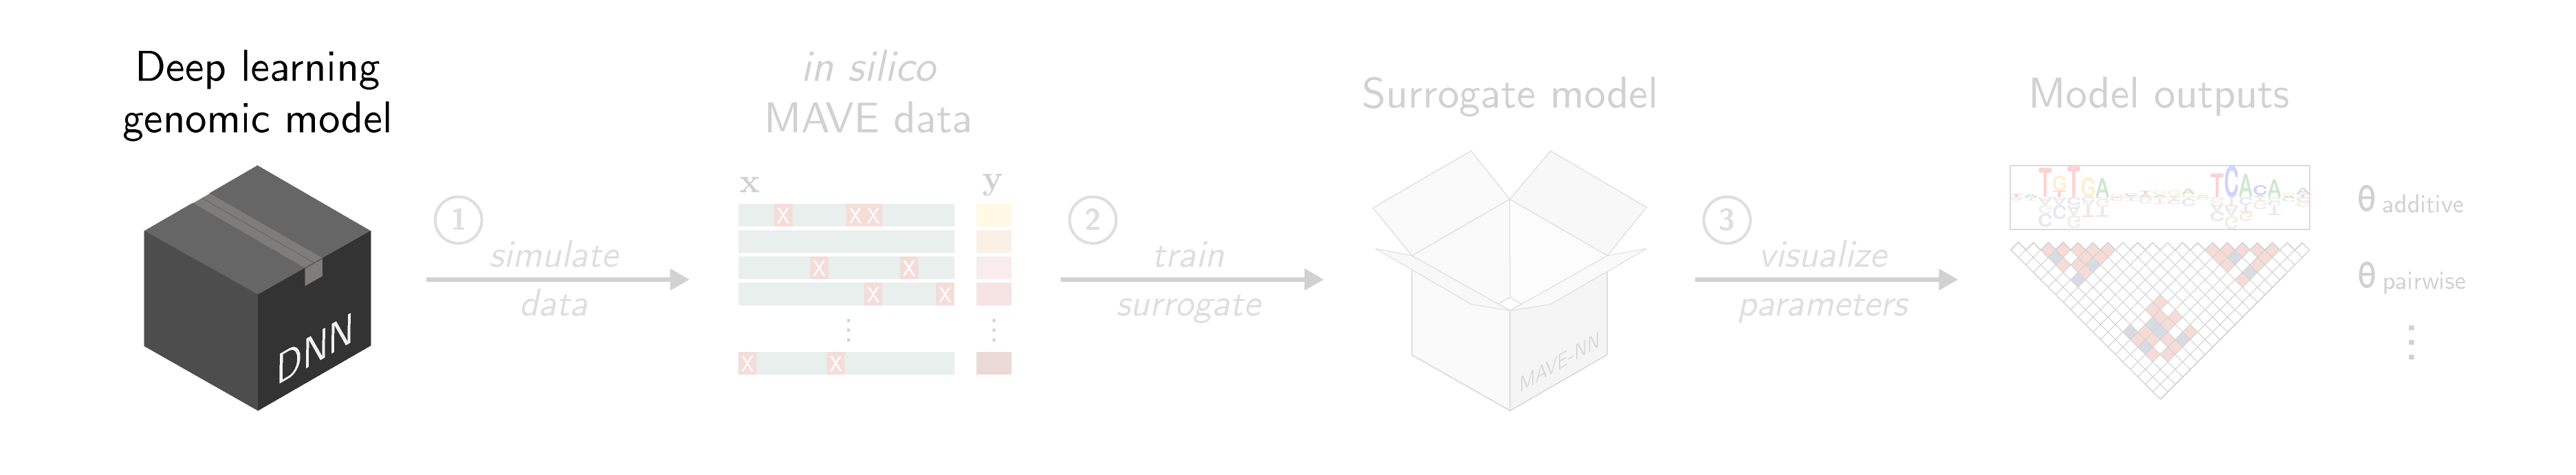

In [5]:
Image("schematic_A.png")

In [6]:
def load_deepstarr_model(model):
  from keras.models import model_from_json
  keras_model_weights = model + '.h5'
  keras_model_json = model + '.json'
  keras_model = model_from_json(open(keras_model_json).read())
  keras_model.load_weights(keras_model_weights)
  return keras_model, keras_model_weights, keras_model_json

model, model_weights, model_json = load_deepstarr_model('/content/DeepSTARR.model')

# Inputs shape:   (n, 249, 4)
# Outputs shape:  (2,)

## Retrieve sequence-of-interest from DeepSTARR test set

In [7]:
def get_fastas_from_file(fasta_path, as_dict=False, uppercase=False, stop_at=None):
    """
    https://github.com/bernardo-de-almeida/DeepSTARR/blob/main/DeepSTARR/Neural_Network_DNA_Demo/helper/IOHelper.py
    """
    fastas = []
    seq = None
    header = None
    for r in open(fasta_path):
        if type(r) is bytes:
            r = r.decode("utf-8")
        r = r.strip()
        if r.startswith(">"):
            if seq != None and header != None:
                fastas.append([header, seq])
                if stop_at != None and len(fastas) >= stop_at:
                    break
            seq = ""
            header = r[1:]
        else:
            if seq != None:
                seq += r.upper() if uppercase else r
            else:
                seq = r.upper() if uppercase else r
    # append last fasta read by method
    if stop_at != None and len(fastas) < stop_at:
        fastas.append([header, seq])
    elif stop_at == None:
        fastas.append([header, seq])
    if as_dict:
        return {h: s for h, s in fastas}

    return pd.DataFrame({'location': [e[0] for e in fastas], 'sequence': [e[1] for e in fastas]})

In [8]:
seq_index = 24869   # example locus with a pronounced GATA motif
task_idx = 0        # developmental (DEV) program
alphabet = ['A','C','G','T']

seqs = get_fastas_from_file('/content/Sequences_Test.fa', uppercase=True)
seq = seqs['sequence'][seq_index]
seq_length = len(seq)
x = squid.utils.seq2oh(seq, alphabet)

# define mutagenesis window for sequence
mut_window = [0, seq_length] # [start_position, stop_position]

## Set up SQUID modules that are dependent on choice of DNN



In [9]:
# set up predictor class for in silico MAVE
pred_generator = squid.predictor.ScalarPredictor(pred_fun=model.predict_on_batch,
                                                 task_idx=task_idx, batch_size=512)

## Set up remaining SQUID modules and perform *in silico* MAVE

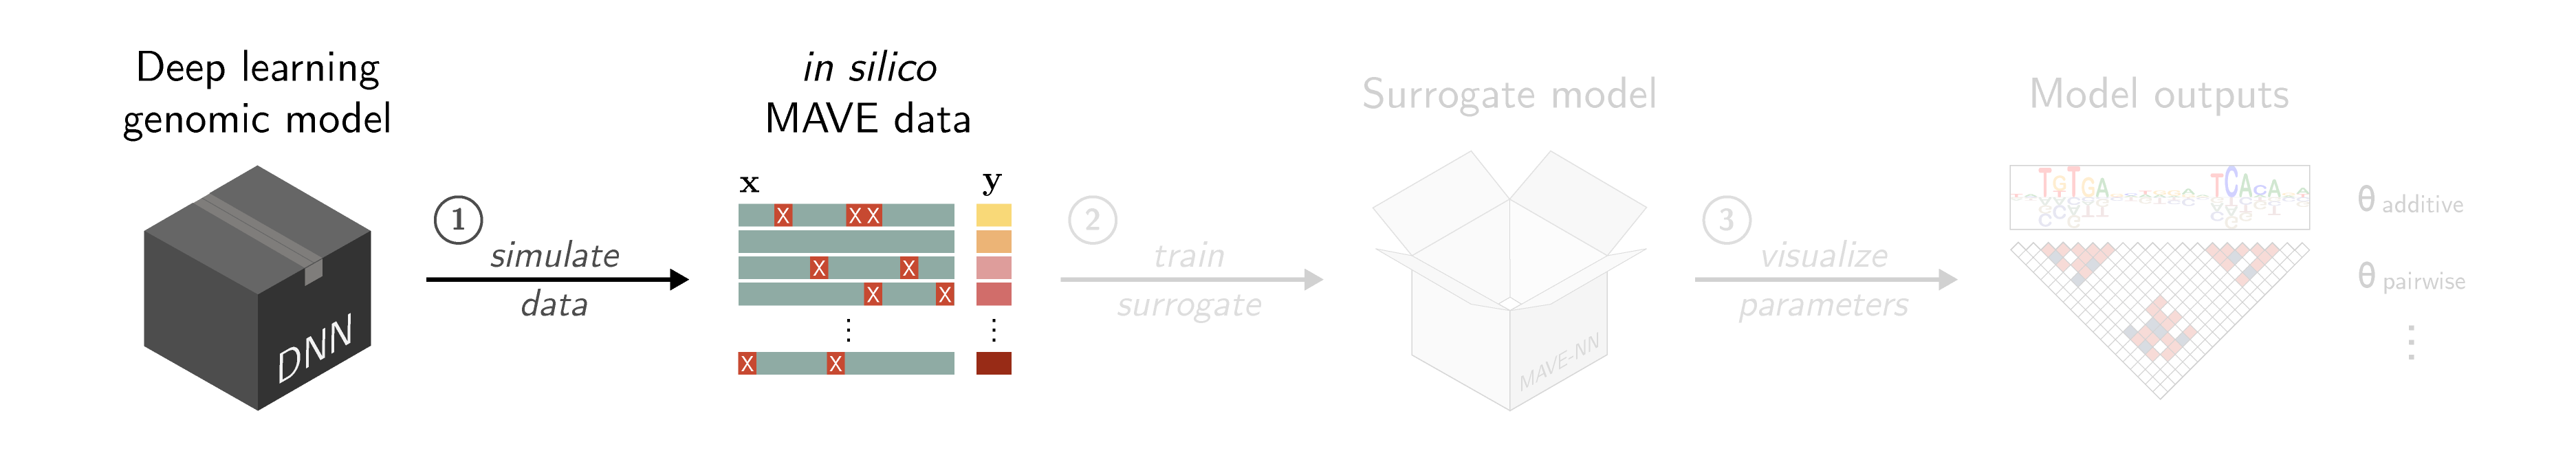

In [10]:
Image("schematic_B.png")

In [11]:
# set up mutagenizer class for in silico MAVE
mut_generator = squid.mutagenizer.RandomMutagenesis(mut_rate=0.1)

# generate in silico MAVE
mave = squid.mave.InSilicoMAVE(mut_generator, pred_generator, seq_length, mut_window=mut_window)
x_mut, y_mut = mave.generate(x, num_sim=30000)


Building in silico MAVE...


Inference: 100%|██████████| 58/58 [00:08<00:00,  6.87it/s]


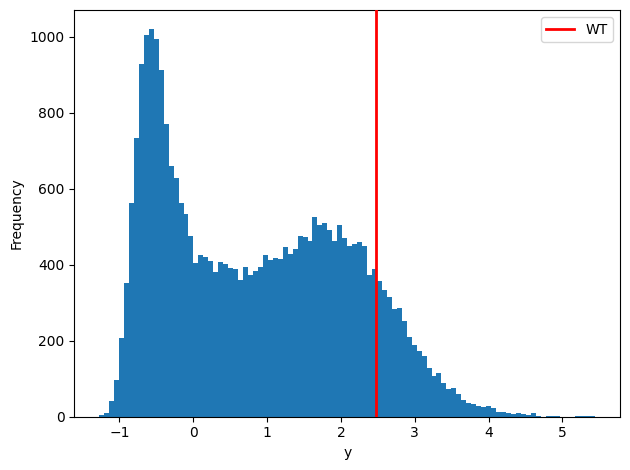

In [12]:
# plot histogram of deepnet predictions
fig = squid.impress.plot_y_hist(y_mut)

## Choose surrogate model and define hyperparameters

In [13]:
# choose surrogate model type
gpmap = 'additive' #{'additive', 'pairwise' if MAVE-NN}

# MAVE-NN model with GE nonlinearity
surrogate_model = squid.surrogate_zoo.SurrogateMAVENN(x_mut.shape, num_tasks=y_mut.shape[1],
                                                      gpmap=gpmap, regression_type='GE',
                                                      linearity='nonlinear', noise='SkewedT',
                                                      noise_order=2, reg_strength=0.1,
                                                      alphabet=alphabet, deduplicate=True,
                                                      gpu=True)

## Train surrogate model

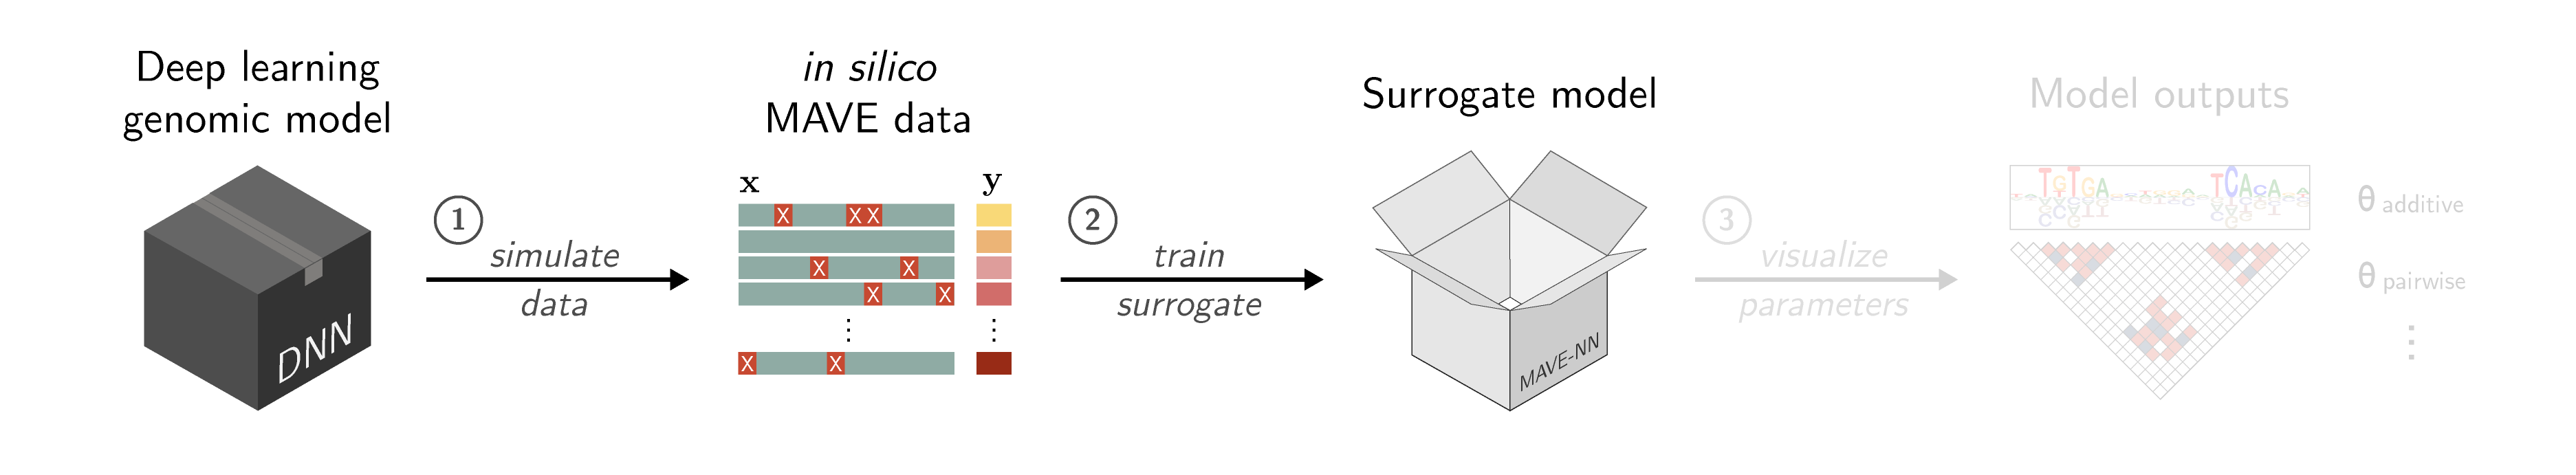

In [14]:
Image("schematic_C.png")

In [15]:
# train surrogate model
surrogate, mave_df = surrogate_model.train(x_mut, y_mut, learning_rate=5e-4, epochs=500, batch_size=100,
                                           early_stopping=True, patience=25, restore_best_weights=True,
                                           save_dir=None, verbose=1)

# retrieve model parameters
params = surrogate_model.get_params(gauge='empirical')

# generate sequence logo
logo = surrogate_model.get_logo(view_window=mut_window, full_length=seq_length)

  Creating sequence dataframe...

              y                                                  x
0      2.478563  GGCTCTGTCTCAGTTTCTGATTCAGTTTCGGATCCACTTCGAGAGG...
1      0.011969  GGCTCTGTCTTAGTTTCTGTTTCAAGTTCTGATACGCTTCGAGAGG...
2      2.316191  GGCTCTGTCTCAGGTTCTGGTTCAGTTTCGGATCCACTTCGAGAGG...
3      1.270063  GGCTCTGCCTCAGTGTCTGGTTCAGGTTTGGATCCACTTCGAGAGG...
4      0.955517  GGCTCGGTCTCAGTTTCTGCTTCAGTTTCGGATACACTTCGAGATG...
...         ...                                                ...
29995  2.445371  GGCTCTGTGTCAGTTTCTGACTCAGTTTCGGATCCTCTTCAAGCGG...
29996 -0.520243  GGCTATGTCTCAGTTTTTGATTCAGTTTCGGACTCACTGCGAGAGG...
29997 -0.119607  GGCTCTGCCTCCTTTTCTGATAGAGTTTCGGATCAACTTCGAGAGG...
29998  0.088501  GGCTCTGCCTCAGTTTCTGATTCAGTTGTGGATCTGCTTCGAGAGG...
29999 -0.414531  GGCTCTGTCATAGTTTCTGATTCAGTTTCGGATCCACTTCGAGAGA...

[30000 rows x 2 columns]
Training set   :   17,816 observations (  59.39%)
Validation set :    6,005 observations (  20.02%)
Test set       :    6,179 observatio

0epoch [00:00, ?epoch/s]

Training time: 294.2 seconds


## Evaluate model performance

In [16]:
trainval_df, test_df = mavenn.split_dataset(mave_df)
info = surrogate_model.get_info()

Training set   :   17,816 observations (  59.39%)
Validation set :    6,005 observations (  20.02%)
Test set       :    6,179 observations (  20.60%)
-------------------------------------------------
Total dataset  :   30,000 observations ( 100.00%)


Model performance:
  test_I_pred: 1.118 +- 0.014 bits
  max I_var: 1.1224671602249146
  max val_I_var: 1.101274847984314



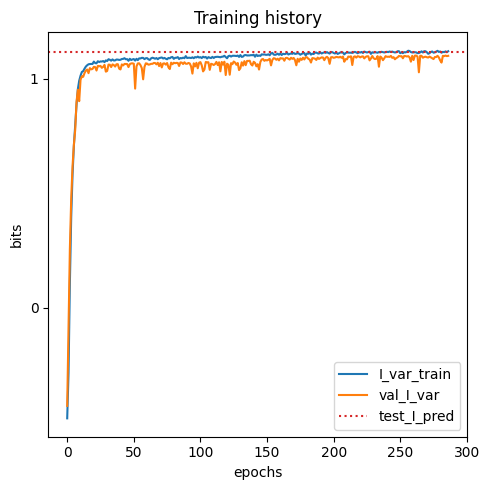

In [17]:
# plot mavenn model performance
fig = squid.impress.plot_performance(surrogate, info=info)

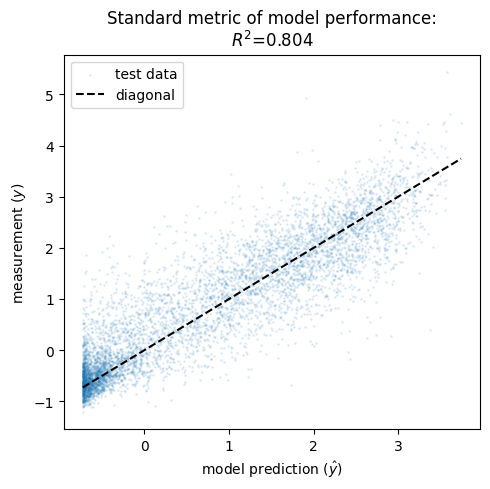

In [18]:
# plot mavenn y versus yhat
fig = squid.impress.plot_y_vs_yhat(surrogate, mave_df=mave_df)

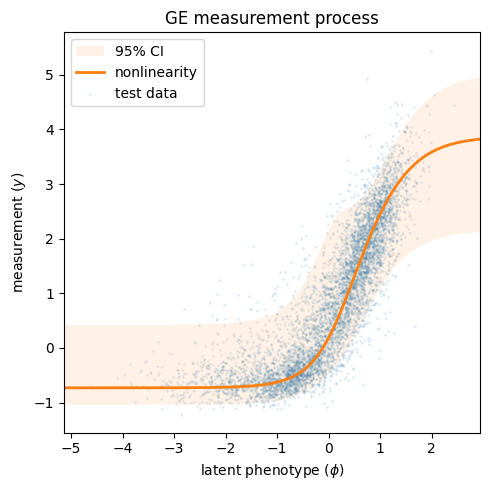

In [19]:
# plot mavenn y versus phi
fig = squid.impress.plot_y_vs_phi(surrogate, mave_df=mave_df)

## Visualize surrogate model parameters

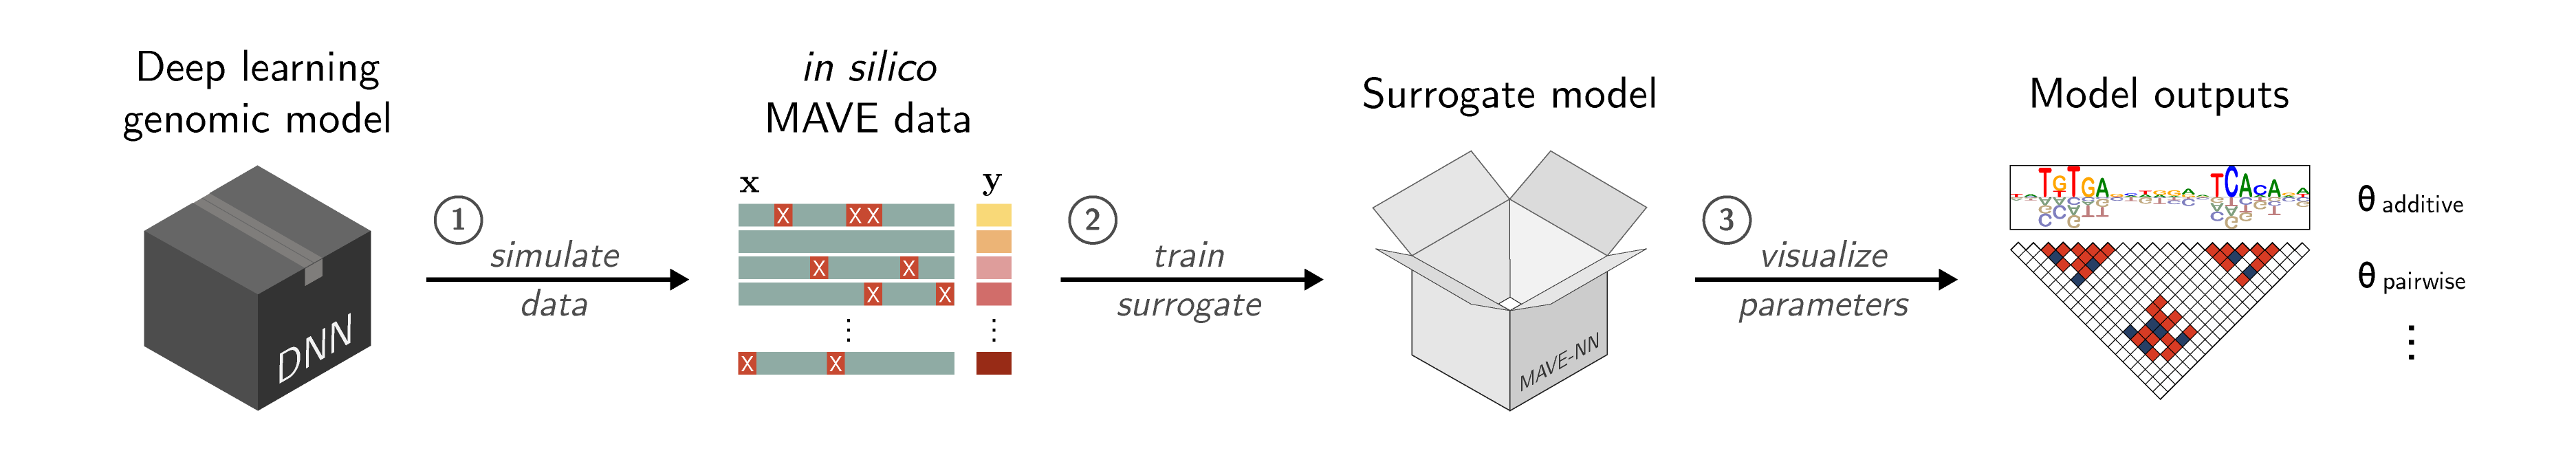

In [20]:
Image("schematic_D.png")

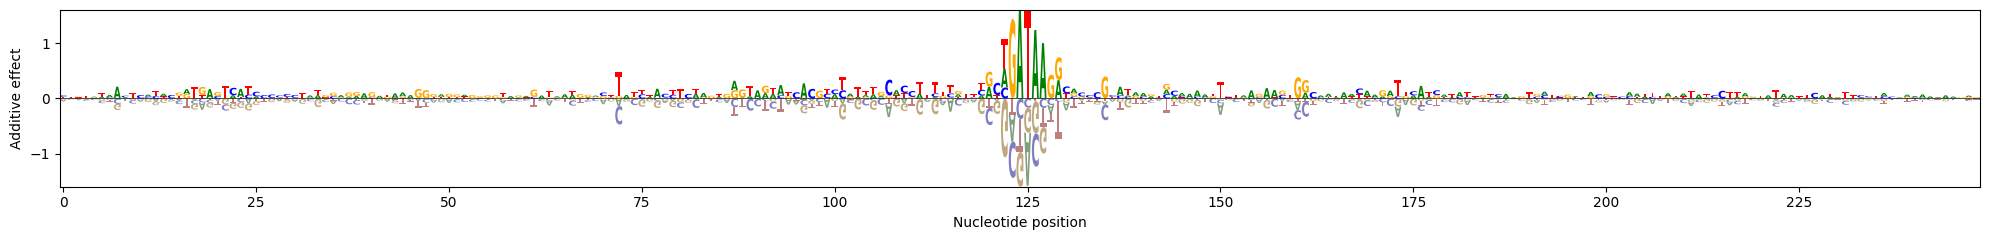

In [21]:
# plot additive logo
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

fig = squid.impress.plot_additive_logo(logo, center=True, view_window=mut_window, alphabet=alphabet, fig_size=[20,2.5])